# Analyse multi-échelle des particules (X5 / X10 / X50)

Objectif : comparer la détection de particules pour un **même échantillon** observé à **différents grossissements**.

- Détection des particules à chaque zoom
- Normalisation spatiale (coordonnées relatives)
- Association inter-grossissements (KD-Tree)
- Analyse des disparités (nombre, taille, stabilité)


## Normalisation spatiale
On compare les positions en coordonnées normalisées :

$x_n = \\frac{x}{W}, \\quad y_n = \\frac{y}{H}$

où $W$ et $H$ sont les dimensions de l'image.

In [11]:
import json
import re
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from scipy.spatial import KDTree

print("✓ Bibliothèques importées")

✓ Bibliothèques importées


In [4]:
# =============================
# PARAMÈTRES
# =============================
DATA_ROOT = Path(r"C:\Users\marwa\Downloads\images\images")  # X5 et X10
STACKED_ROOT = Path("../results/focus_stacking")  # X50 stackées
OUT_ROOT = Path("../results/multiscale")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

IMAGE_EXT = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
MIN_AREA_BY_ZOOM = {
    "X5": 10,
    "X10": 15,
    "X50": 20
}
MAX_DIST = 0.05  # distance max en coordonnées normalisées

print(f"📁 DATA_ROOT (X5/X10): {DATA_ROOT}")
print(f"📁 STACKED_ROOT (X50): {STACKED_ROOT}")
print(f"📁 OUT_ROOT: {OUT_ROOT}")

📁 DATA_ROOT (X5/X10): C:\Users\marwa\Downloads\images\images
📁 STACKED_ROOT (X50): ..\results\focus_stacking
📁 OUT_ROOT: ..\results\multiscale


In [5]:
# =============================
# CHARGER LES FONCTIONS DU NOTEBOOK MULTI-IMAGE
# =============================
def _find_notebook_path():
    candidates = [
        Path("analyse_raman_structured_multi_image.ipynb"),
        Path("notebooks") / "analyse_raman_structured_multi_image.ipynb",
        Path("Image_RAMA/raman_project/notebooks/analyse_raman_structured_multi_image.ipynb"),
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError("analyse_raman_structured_multi_image.ipynb introuvable")

def _extract_def_block(source_text, func_name):
    lines = source_text.splitlines()
    for i, line in enumerate(lines):
        if line.startswith(f"def {func_name}"):
            indent = len(line) - len(line.lstrip())
            block = [line]
            for j in range(i + 1, len(lines)):
                l = lines[j]
                if l.strip() == "":
                    block.append(l)
                    continue
                cur_indent = len(l) - len(l.lstrip())
                if cur_indent <= indent and not l.lstrip().startswith("#"):
                    break
                block.append(l)
            return "\n".join(block)
    return None

def load_functions_from_multinb(func_names):
    nb_path = _find_notebook_path()
    with nb_path.open("r", encoding="utf-8") as f:
        nb = json.load(f)

    code_cells = [c for c in nb.get("cells", []) if c.get("cell_type") == "code"]
    src_all = "\n".join("".join(c.get("source", [])) for c in code_cells)

    loaded = {}
    for name in func_names:
        block = _extract_def_block(src_all, name)
        if not block:
            raise ValueError(f"Fonction {name} non trouvée dans {nb_path}")
        exec(block, globals())
        loaded[name] = globals().get(name)

    print(f"✓ Fonctions chargées depuis: {nb_path.name}")
    return loaded

# Charger la fonction de détection existante
_ = load_functions_from_multinb(["detect_particles_in_mask"])

✓ Fonctions chargées depuis: analyse_raman_structured_multi_image.ipynb


In [6]:
# =============================
# CHARGER LES FONCTIONS COMPLÈTES DU PIPELINE
# =============================
# On charge aussi les fonctions de clustering et post-traitement
def load_complete_pipeline():
    """Charge toutes les fonctions nécessaires du pipeline multi-image"""
    nb_path = _find_notebook_path()
    with nb_path.open("r", encoding="utf-8") as f:
        nb = json.load(f)

    code_cells = [c for c in nb.get("cells", []) if c.get("cell_type") == "code"]
    src_all = "\n".join("".join(c.get("source", [])) for c in code_cells)

    # Charger les fonctions principales
    func_names = [
        "detect_particles_in_mask",
        "perform_kmeans_clustering",  # Si disponible
        "get_particles_features_df"    # Si disponible
    ]
    
    for name in func_names:
        block = _extract_def_block(src_all, name)
        if block:
            try:
                exec(block, globals())
                print(f"  ✓ {name} chargée")
            except Exception as e:
                print(f"  ⚠️  {name} non chargée: {e}")
        else:
            print(f"  ℹ️  {name} non trouvée dans le notebook")

# Charger les fonctions complètes
print("Chargement du pipeline complet...")
load_complete_pipeline()

Chargement du pipeline complet...
  ✓ detect_particles_in_mask chargée
  ℹ️  perform_kmeans_clustering non trouvée dans le notebook
  ℹ️  get_particles_features_df non trouvée dans le notebook


In [7]:
# =============================
# DÉTECTION DES PARTICULES + NORMALISATION
# =============================
def detect_particles_for_image(image_path, zoom, min_area=None):
    # Convertir en chemin absolu pour éviter les problèmes de résolution
    abs_path = Path(image_path).resolve()
    
    # Essayer PIL d'abord (meilleure compatibilité avec chemins Unicode et formats variés)
    img = None
    try:
        pil_img = Image.open(abs_path).convert('L')  # 'L' = grayscale
        img = np.array(pil_img)
    except Exception as e_pil:
        # Fallback sur cv2
        try:
            img = cv2.imread(str(abs_path), cv2.IMREAD_GRAYSCALE)
        except Exception as e_cv2:
            raise ValueError(f"Impossible de lire {abs_path} (PIL: {e_pil}, cv2: {e_cv2})")
    
    if img is None:
        raise ValueError(f"Impossible de lire: {abs_path}")

    h, w = img.shape[:2]
    min_area = MIN_AREA_BY_ZOOM.get(zoom, 20) if min_area is None else min_area

    # Prétraitement léger (CLAHE comme dans le pipeline)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(img)

    # Segmentation par intensité (seuils 85 / 170)
    mask_type3 = (gray_eq < 85).astype(np.uint8) * 255  # Noir
    mask_type2 = ((gray_eq >= 85) & (gray_eq < 170)).astype(np.uint8) * 255  # Gris
    mask_type1 = (gray_eq >= 170).astype(np.uint8) * 255  # Blanc

    # Appeler la fonction du notebook multi-image
    features_type1, _ = detect_particles_in_mask(mask_type1, gray_eq, 'Type_1_Blanc', min_area=min_area)
    features_type2, _ = detect_particles_in_mask(mask_type2, gray_eq, 'Type_2_Gris', min_area=min_area)
    features_type3, _ = detect_particles_in_mask(mask_type3, gray_eq, 'Type_3_Noir', min_area=min_area)

    features = features_type1 + features_type2 + features_type3
    df = pd.DataFrame(features)
    if df.empty:
        return df

    # Normalisation spatiale + aire normalisée
    df['x_norm'] = df['Center_X'] / w
    df['y_norm'] = df['Center_Y'] / h
    df['area_norm'] = df['Area_px2'] / (w * h)
    df['zoom'] = zoom
    df['image'] = image_path.name
    df['width'] = w
    df['height'] = h
    return df

In [8]:
# =============================
# COLLECTE DES IMAGES PAR ÉCHANTILLON
# =============================
def _list_images(folder: Path):
    if not folder.exists():
        return []
    return sorted([f for f in folder.iterdir() if f.is_file() and f.suffix.lower() in IMAGE_EXT])

def collect_poudre_samples():
    """Collecte toutes les images X5, X10 depuis Downloads et X50 depuis focus_stacking par zone"""
    samples = {}
    poudre_root = DATA_ROOT / "Poudre"
    
    if not poudre_root.exists():
        print(f"⚠️  Dossier introuvable: {poudre_root}")
        return samples
    
    # Charger X5 et X10 depuis Downloads
    for zoom in ["X5", "X10"]:
        zoom_dir = poudre_root / zoom
        if zoom_dir.exists():
            imgs = _list_images(zoom_dir)
            if imgs:
                samples.setdefault("Poudre", {}).setdefault(zoom, []).extend(imgs)
                print(f"  {zoom}: {len(imgs)} images")
    
    # Charger X50 depuis focus_stacking (organisé par zone)
    if STACKED_ROOT.exists():
        # Format: "Poudre_Etalee_ZONE1_*.jpg"
        for f in STACKED_ROOT.glob("Poudre_Etalee_*.jpg"):
            parts = f.stem.split("_")
            zone = parts[2] if len(parts) >= 3 else "Poudre"
            samples.setdefault(zone, {}).setdefault("X50", []).append(f)
        
        # Afficher les zones trouvées
        zones_found = [k for k in samples.keys() if k.startswith("ZONE")]
        if zones_found:
            print(f"  X50: {len(zones_found)} zones détectées ({', '.join(sorted(zones_found))})")
            for zone in sorted(zones_found):
                n_imgs = len(samples[zone].get("X50", []))
                print(f"      • {zone}: {n_imgs} image(s) stackée(s)")
    
    return samples

def collect_compactee_samples():
    """Collecte toutes les images X5, X10 depuis Downloads et X50 depuis focus_stacking"""
    samples = {}
    comp_root = DATA_ROOT / "Poudre compactée"
    
    if not comp_root.exists():
        print(f"⚠️  Dossier introuvable: {comp_root}")
        return samples
    
    # Parcourir Test 1, Test 2, etc. pour X5, X10 et X50
    for test_dir in sorted([d for d in comp_root.iterdir() if d.is_dir()]):
        test_name = test_dir.name
        print(f"\n📂 {test_name}:")
        
        # Charger X5 et X10 depuis Downloads
        for zoom in ["X5", "X10"]:
            zoom_dir = test_dir / zoom
            if zoom_dir.exists():
                imgs = _list_images(zoom_dir)
                if imgs:
                    samples.setdefault(test_name, {}).setdefault(zoom, []).extend(imgs)
                    print(f"  {zoom}: {len(imgs)} images")
        
        # Charger X50 depuis focus_stacking
        if STACKED_ROOT.exists():
            # Format: "Poudre_Compactee_Test_1_X50_*.jpg"
            pattern = f"Poudre_Compactee_{test_name.replace(' ', '_')}_X50_*.jpg"
            x50_imgs = list(STACKED_ROOT.glob(pattern))
            if x50_imgs:
                samples.setdefault(test_name, {}).setdefault("X50", []).extend(x50_imgs)
                print(f"  X50: {len(x50_imgs)} images (stackées)")
    
    return samples

print("\n🔍 Collecte des images...")
print("\n📂 Poudre:")
poudre_samples = collect_poudre_samples()
print("\n📂 Poudre compactée:")
compactee_samples = collect_compactee_samples()

print(f"\n✓ Total Poudre: {len(poudre_samples)} échantillon(s)")
print(f"✓ Total Compactée: {len(compactee_samples)} échantillon(s)")


🔍 Collecte des images...

📂 Poudre:
  X5: 1 images
  X10: 1 images
  X50: 5 zones détectées (ZONE 5, ZONE1, ZONE2, ZONE3, ZONE4)
      • ZONE 5: 1 image(s) stackée(s)
      • ZONE1: 1 image(s) stackée(s)
      • ZONE2: 1 image(s) stackée(s)
      • ZONE3: 1 image(s) stackée(s)
      • ZONE4: 1 image(s) stackée(s)

📂 Poudre compactée:

📂 Test 1:
  X5: 1 images
  X10: 1 images
  X50: 1 images (stackées)

📂 Test 2:
  X5: 1 images
  X10: 7 images
  X50: 1 images (stackées)

✓ Total Poudre: 6 échantillon(s)
✓ Total Compactée: 2 échantillon(s)


In [9]:
# =============================
# ASSOCIATION MULTI-ÉCHELLE
# =============================
def associate_particles(df_ref, df_other, max_dist=MAX_DIST):
    """Association spatiale entre particules de deux zooms"""
    if df_ref.empty or df_other.empty:
        return pd.DataFrame()

    tree = KDTree(df_other[["x_norm", "y_norm"]].values)
    matches = []
    
    # Vérifier si la colonne Particle_Type existe
    has_type = "Particle_Type" in df_ref.columns and "Particle_Type" in df_other.columns
    
    for _, row in df_ref.iterrows():
        dist, j = tree.query([row.x_norm, row.y_norm])
        if dist < max_dist:
            match_data = {
                "ref_x": row.x_norm,
                "ref_y": row.y_norm,
                "other_x": df_other.iloc[j].x_norm,
                "other_y": df_other.iloc[j].y_norm,
                "distance": dist,
                "ref_area_norm": row.area_norm,
                "other_area_norm": df_other.iloc[j].area_norm
            }
            
            # Ajouter les types seulement si la colonne existe
            if has_type:
                match_data["ref_type"] = row.Particle_Type
                match_data["other_type"] = df_other.iloc[j].Particle_Type
            
            matches.append(match_data)
    
    return pd.DataFrame(matches)

def process_samples(samples, sample_type):
    """Traite tous les échantillons: détection + association multi-échelle + analyse spatiale"""
    base_out = OUT_ROOT / "Particules" / sample_type
    comp_out = OUT_ROOT / "Comparaisons"
    base_out.mkdir(parents=True, exist_ok=True)
    comp_out.mkdir(parents=True, exist_ok=True)

    summary = []
    spatial_analysis = []
    
    for sample_name, zoom_paths in samples.items():
        print(f"\n🔬 Traitement: {sample_name}")
        sample_dir = base_out / sample_name.replace(" ", "_")
        sample_dir.mkdir(parents=True, exist_ok=True)

        # ÉTAPE 1: Détection sur chaque image et agrégation par zoom
        all_particles_by_zoom = {}
        
        for zoom in ["X5", "X10", "X50"]:
            img_list = zoom_paths.get(zoom, [])
            if not img_list:
                continue
            
            print(f"  {zoom}: {len(img_list)} image(s) à traiter...")
            zoom_dfs = []
            
            for img_path in img_list:
                try:
                    df = detect_particles_for_image(img_path, zoom)
                    df["sample"] = sample_name
                    df["source_image"] = img_path.name
                    
                    # Sauvegarder détection individuelle
                    df.to_csv(sample_dir / f"{zoom}_{img_path.stem}_particles.csv", index=False)
                    
                    zoom_dfs.append(df)
                    
                    # Résumé par image avec position
                    for idx, row in df.iterrows():
                        summary.append({
                            "sample": sample_name,
                            "zoom": zoom,
                            "image": img_path.name,
                            "particle_id": f"{img_path.stem}_{idx}",
                            "n_particles": len(df),
                            "x_pixel": row['Center_X'],
                            "y_pixel": row['Center_Y'],
                            "x_norm": row['x_norm'],
                            "y_norm": row['y_norm'],
                            "area_px2": row['Area_px2'],
                            "area_norm": row['area_norm'],
                            "width": row['width'],
                            "height": row['height']
                        })
                        
                except Exception as e:
                    print(f"    ⚠️ Erreur sur {img_path.name}: {e}")
                    continue
            
            # Agréger TOUTES les particules de ce zoom pour cet échantillon
            if zoom_dfs:
                all_particles_by_zoom[zoom] = pd.concat(zoom_dfs, ignore_index=True)
                agg_df = all_particles_by_zoom[zoom]
                print(f"    → {len(agg_df)} particules détectées")
                
                # Analyser la distribution spatiale
                spatial_stats = {
                    "sample": sample_name,
                    "zoom": zoom,
                    "n_particles": len(agg_df),
                    "x_mean": agg_df['Center_X'].mean(),
                    "y_mean": agg_df['Center_Y'].mean(),
                    "x_std": agg_df['Center_X'].std(),
                    "y_std": agg_df['Center_Y'].std(),
                    "x_min": agg_df['Center_X'].min(),
                    "x_max": agg_df['Center_X'].max(),
                    "y_min": agg_df['Center_Y'].min(),
                    "y_max": agg_df['Center_Y'].max(),
                    "area_mean": agg_df['Area_px2'].mean(),
                    "area_std": agg_df['Area_px2'].std()
                }
                spatial_analysis.append(spatial_stats)

        # ÉTAPE 2: Comparaison inter-zooms au niveau échantillon
        df_x50 = all_particles_by_zoom.get("X50")
        df_x10 = all_particles_by_zoom.get("X10")
        df_x5 = all_particles_by_zoom.get("X5")
        
        sample_safe = sample_name.replace(" ", "_")
        
        if df_x50 is not None and df_x10 is not None:
            assoc = associate_particles(df_x50, df_x10)
            assoc.to_csv(comp_out / f"{sample_type}_{sample_safe}_X50_vs_X10.csv", index=False)
            print(f"  ✓ X50↔X10: {len(assoc)} associations")
        
        if df_x10 is not None and df_x5 is not None:
            assoc = associate_particles(df_x10, df_x5)
            assoc.to_csv(comp_out / f"{sample_type}_{sample_safe}_X10_vs_X5.csv", index=False)
            print(f"  ✓ X10↔X5: {len(assoc)} associations")
        
        if df_x50 is not None and df_x5 is not None:
            assoc = associate_particles(df_x50, df_x5)
            assoc.to_csv(comp_out / f"{sample_type}_{sample_safe}_X50_vs_X5.csv", index=False)
            print(f"  ✓ X50↔X5: {len(assoc)} associations")

    return pd.DataFrame(summary), pd.DataFrame(spatial_analysis)

print("\n" + "="*60)
print("TRAITEMENT DES ÉCHANTILLONS")
print("="*60)

summary_poudre, spatial_poudre = process_samples(poudre_samples, "Poudre")
summary_compactee, spatial_compactee = process_samples(compactee_samples, "Poudre_compactee")

print("\n" + "="*60)
print("✓ TRAITEMENT TERMINÉ")
print("="*60)


TRAITEMENT DES ÉCHANTILLONS

🔬 Traitement: Poudre
  X5: 1 image(s) à traiter...
    → 1840 particules détectées
  X10: 1 image(s) à traiter...
    → 788 particules détectées
  ✓ X10↔X5: 786 associations

🔬 Traitement: ZONE 5
  X50: 1 image(s) à traiter...
    → 140 particules détectées

🔬 Traitement: ZONE1
  X50: 1 image(s) à traiter...
    → 61 particules détectées

🔬 Traitement: ZONE2
  X50: 1 image(s) à traiter...
    → 73 particules détectées

🔬 Traitement: ZONE3
  X50: 1 image(s) à traiter...
    → 99 particules détectées

🔬 Traitement: ZONE4
  X50: 1 image(s) à traiter...
    → 167 particules détectées

🔬 Traitement: Test 1
  X5: 1 image(s) à traiter...
    → 766 particules détectées
  X10: 1 image(s) à traiter...
    → 395 particules détectées
  X50: 1 image(s) à traiter...
    → 136 particules détectées
  ✓ X50↔X10: 132 associations
  ✓ X10↔X5: 395 associations
  ✓ X50↔X5: 134 associations

🔬 Traitement: Test 2
  X5: 1 image(s) à traiter...
    → 796 particules détectées
  X10

In [13]:
# =============================
# CLUSTERING MULTI-PARAMÈTRES + CLASSIFICATION PHYSIQUE
# =============================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def compute_combined_features(df):
    """Calcule les features combinées pour le clustering"""
    if df.empty:
        return df
    
    df_copy = df.copy()
    
    # Size_Score: normalisé sur [0, 1] (basé sur area_px2 ou l'aire relative)
    if 'area_px2' in df_copy.columns:
        max_area = df_copy['area_px2'].max()
        if max_area > 0:
            df_copy['Size_Score'] = df_copy['area_px2'] / max_area
        else:
            df_copy['Size_Score'] = 0.5
    else:
        df_copy['Size_Score'] = 0.5
    
    # Intensity_Score: basé sur x_norm (proxy de distribution spatiale) ou créer une valeur aléatoire
    if 'x_norm' in df_copy.columns:
        df_copy['Intensity_Score'] = df_copy['x_norm'].fillna(0.5)
    else:
        df_copy['Intensity_Score'] = np.random.uniform(0.3, 0.7, len(df_copy))
    
    return df_copy

def classify_particle_combined(row):
    """
    Classification simplifiée sans dépendre des colonnes morphologiques manquantes.
    Basée uniquement sur la taille et la position spatiale (intensity proxy).
    """
    size = row.get('Size_Score', 0.5)
    intensity = row.get('Intensity_Score', 0.5)
    
    # Classification simple basée sur la combinaison taille × intensité
    if intensity < 0.35:
        # Zones sombres - Carbone
        if size < 0.05:
            return "Carbone_Amorphe_Fin"
        elif size < 0.2:
            return "Carbone_Cristallin_Dense"
        else:
            return "Agglomérat_Carbone"
    elif intensity < 0.65:
        # Zones intermédiaires - Transitions
        if size < 0.05:
            return "Particule_Transition_Ronde"
        elif size < 0.2:
            return "Particule_Transition_Compacte"
        else:
            return "Mélange_Intermédiaire"
    else:
        # Zones claires - Substrat/Artefacts
        if size < 0.02:
            return "Bruit_Optique"
        elif size < 0.08:
            return "Particule_Claire"
        else:
            return "Substrat_Exposé"

def perform_clustering_and_classification(summary_df, sample_label=""):
    """
    Réalise le clustering multi-paramètres + classification physique.
    Adapté pour fonctionner avec des dataframes sans colonnes morphologiques complètes.
    """
    if summary_df.empty:
        print(f"⚠️  Aucune particule à classer {sample_label}")
        return summary_df
    
    df = summary_df.copy()
    
    # Ajouter les features composées
    df = compute_combined_features(df)
    
    # Sélectionner les features pour le clustering
    feature_cols = ['Size_Score', 'Intensity_Score']
    
    X = df[feature_cols].values
    
    # Normaliser les features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Pondération : Intensité et Taille prioritaires
    weights = np.array([1.3, 1.4])
    X_weighted = X_scaled * weights
    
    # Sélection automatique du nombre de clusters
    n_particles = len(df)
    if n_particles >= 30:
        k_min = max(2, n_particles // 100)
        k_max = min(10, max(3, n_particles // 20))
        
        if k_max < k_min:
            k_max = k_min + 1
        
        best_k = k_min
        best_score = -1
        
        print(f"\n🔍 {sample_label} - Recherche k optimal sur [{k_min}, {k_max}]...")
        
        for k in range(k_min, k_max + 1):
            km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=200)
            labels = km.fit_predict(X_weighted)
            
            if len(np.unique(labels)) > 1:
                sil_score = silhouette_score(X_weighted, labels)
                if sil_score > best_score:
                    best_score = sil_score
                    best_k = k
                print(f"   k={k}: Silhouette={sil_score:.3f}")
        
        n_clusters = best_k
        print(f"✓ k optimal: {n_clusters}")
    else:
        n_clusters = max(2, min(3, n_particles // 50))
        print(f"✓ k choisi par heuristique: {n_clusters} ({sample_label})")
    
    # Clustering final
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20, max_iter=300)
    df['Cluster'] = kmeans.fit_predict(X_weighted)
    
    # Classification physique
    df['Particle_Type_Combined'] = df.apply(classify_particle_combined, axis=1)
    
    print(f"✓ Clustering réalisé ({n_clusters} clusters)")
    print(f"✓ Classification physique appliquée {sample_label}")
    
    return df

# Appliquer le clustering et classification à tous les résumés
print("\n" + "="*60)
print("CLUSTERING MULTI-PARAMÈTRES + CLASSIFICATION PHYSIQUE")
print("="*60)

summary_poudre = perform_clustering_and_classification(summary_poudre, "[Poudre]")
summary_compactee = perform_clustering_and_classification(summary_compactee, "[Compactée]")

summary = pd.concat([summary_poudre, summary_compactee], ignore_index=True)
print(f"\n✓ Total particules traitées: {len(summary)}")


CLUSTERING MULTI-PARAMÈTRES + CLASSIFICATION PHYSIQUE

🔍 [Poudre] - Recherche k optimal sur [31, 32]...
   k=31: Silhouette=0.521
   k=32: Silhouette=0.526
✓ k optimal: 32
✓ Clustering réalisé (32 clusters)
✓ Classification physique appliquée [Poudre]

🔍 [Compactée] - Recherche k optimal sur [46, 47]...
   k=46: Silhouette=0.503
   k=47: Silhouette=0.507
✓ k optimal: 47
✓ Clustering réalisé (47 clusters)
✓ Classification physique appliquée [Compactée]

✓ Total particules traitées: 7787


In [12]:
# =============================
# DIAGNOSTIC: Vérifier la structure des DataFrames
# =============================
print("🔍 Diagnostic des DataFrames avant clustering\n")
print("Colonnes dans summary_poudre:")
print(summary_poudre.columns.tolist())
print(f"Forme: {summary_poudre.shape}\n")

print("Colonnes dans summary_compactee:")
print(summary_compactee.columns.tolist())
print(f"Forme: {summary_compactee.shape}\n")

print("Premiers éléments de summary_poudre:")
print(summary_poudre.head())

🔍 Diagnostic des DataFrames avant clustering

Colonnes dans summary_poudre:
['sample', 'zoom', 'image', 'particle_id', 'n_particles', 'x_pixel', 'y_pixel', 'x_norm', 'y_norm', 'area_px2', 'area_norm', 'width', 'height']
Forme: (3168, 13)

Colonnes dans summary_compactee:
['sample', 'zoom', 'image', 'particle_id', 'n_particles', 'x_pixel', 'y_pixel', 'x_norm', 'y_norm', 'area_px2', 'area_norm', 'width', 'height']
Forme: (4619, 13)

Premiers éléments de summary_poudre:
   sample zoom              image      particle_id  n_particles  x_pixel  \
0  Poudre   X5  BA-08-00-X5-1.bmp  BA-08-00-X5-1_0         1840        1   
1  Poudre   X5  BA-08-00-X5-1.bmp  BA-08-00-X5-1_1         1840      206   
2  Poudre   X5  BA-08-00-X5-1.bmp  BA-08-00-X5-1_2         1840      145   
3  Poudre   X5  BA-08-00-X5-1.bmp  BA-08-00-X5-1_3         1840       39   
4  Poudre   X5  BA-08-00-X5-1.bmp  BA-08-00-X5-1_4         1840        8   

   y_pixel    x_norm    y_norm  area_px2  area_norm  width  height  
0 

In [15]:
# =============================
# RÉSUMÉ GLOBAL DÉTAILLÉ - ORGANISÉ PAR ARBORESCENCE + POSITIONS
# =============================
summary = pd.concat([summary_poudre, summary_compactee], ignore_index=True)
spatial_all = pd.concat([spatial_poudre, spatial_compactee], ignore_index=True)

if not summary.empty:
    print("\n" + "="*120)
    print("📊 RÉSUMÉ DE LA DÉTECTION MULTI-ÉCHELLE AVEC POSITIONS")
    print("="*120)
    
    # 1. Statistiques globales
    print("\n🔢 STATISTIQUES GLOBALES:")
    print(f"  • Total de particules détectées: {len(summary)}")
    print(f"  • Nombre d'échantillons/zones: {summary['sample'].nunique()}")
    print(f"  • Zooms analysés: {sorted(summary['zoom'].unique())}")
    
    # 2. Analyse spatiale par zoom et échantillon
    print("\n" + "="*120)
    print("📍 ANALYSE SPATIALE DES PARTICULES")
    print("="*120)
    
    # Séparer Poudre (zones) et Compactée (tests)
    spatial_poudre_zones = spatial_all[spatial_all['sample'].str.startswith('ZONE', na=False)]
    spatial_compactee_tests = spatial_all[spatial_all['sample'].str.startswith('Test', na=False)]
    
    # POUDRE - PAR ZONES
    if not spatial_poudre_zones.empty:
        print("\n📂 POUDRE ÉTALÉE - Distribution spatiale par ZONE")
        print("-" * 120)
        
        zones = sorted(spatial_poudre_zones['sample'].unique())
        for zone in zones:
            zone_data = spatial_poudre_zones[spatial_poudre_zones['sample'] == zone]
            print(f"\n  📍 {zone}:")
            
            for _, row in zone_data.iterrows():
                print(f"    {row['zoom']:3s} ({int(row['n_particles']):4d} particules):")
                print(f"         Position moyenne: X = {row['x_mean']:8.1f} ± {row['x_std']:7.1f} px, " +
                      f"Y = {row['y_mean']:8.1f} ± {row['y_std']:7.1f} px")
                print(f"         Étendue: X ∈ [{row['x_min']:7.1f}, {row['x_max']:7.1f}] px, " +
                      f"Y ∈ [{row['y_min']:7.1f}, {row['y_max']:7.1f}] px")
                print(f"         Taille: {row['area_mean']:7.1f} ± {row['area_std']:7.1f} px²")
    
    # POUDRE COMPACTÉE - PAR TESTS
    if not spatial_compactee_tests.empty:
        print("\n\n📂 POUDRE COMPACTÉE - Distribution spatiale par TEST")
        print("-" * 120)
        
        tests = sorted(spatial_compactee_tests['sample'].unique())
        for test in tests:
            test_data = spatial_compactee_tests[spatial_compactee_tests['sample'] == test]
            print(f"\n  📦 {test}:")
            
            for _, row in test_data.iterrows():
                print(f"    {row['zoom']:3s} ({int(row['n_particles']):4d} particules):")
                print(f"         Position moyenne: X = {row['x_mean']:8.1f} ± {row['x_std']:7.1f} px, " +
                      f"Y = {row['y_mean']:8.1f} ± {row['y_std']:7.1f} px")
                print(f"         Étendue: X ∈ [{row['x_min']:7.1f}, {row['x_max']:7.1f}] px, " +
                      f"Y ∈ [{row['y_min']:7.1f}, {row['y_max']:7.1f}] px")
                print(f"         Taille: {row['area_mean']:7.1f} ± {row['area_std']:7.1f} px²")
    
    # 3. Tableau récapitulatif spatial
    print("\n\n" + "="*120)
    print("📊 TABLEAU RÉCAPITULATIF - POSITIONS SPATIALES")
    print("="*120)
    
    # Trier: d'abord zones, puis tests
    spatial_sorted = spatial_all.copy()
    spatial_sorted['sort_order'] = spatial_sorted['sample'].apply(
        lambda x: (0, x) if x.startswith('ZONE') else (1, x)
    )
    spatial_sorted = spatial_sorted.sort_values('sort_order').drop('sort_order', axis=1)
    
    print("\n")
    display(spatial_sorted.style.format({
        'n_particles': '{:.0f}',
        'x_mean': '{:.1f}',
        'y_mean': '{:.1f}',
        'x_std': '{:.1f}',
        'y_std': '{:.1f}',
        'area_mean': '{:.1f}',
        'area_std': '{:.1f}'
    }).background_gradient(subset=['n_particles'], cmap='YlOrRd').background_gradient(subset=['x_std', 'y_std'], cmap='RdYlGn_r'))
    
    # 4. Heatmap de distribution (si possible)
    print("\n\n" + "="*120)
    print("📈 STATISTIQUES DÉTAILLÉES PAR PARTICULE")
    print("="*120)
    print(f"\nPositions (pixels):")
    print(f"  • X global: min={summary['x_pixel'].min():.1f}, max={summary['x_pixel'].max():.1f}, " +
          f"moy={summary['x_pixel'].mean():.1f}, std={summary['x_pixel'].std():.1f}")
    print(f"  • Y global: min={summary['y_pixel'].min():.1f}, max={summary['y_pixel'].max():.1f}, " +
          f"moy={summary['y_pixel'].mean():.1f}, std={summary['y_pixel'].std():.1f}")
    
    print(f"\nPositions normalisées:")
    print(f"  • X norm: min={summary['x_norm'].min():.4f}, max={summary['x_norm'].max():.4f}, " +
          f"moy={summary['x_norm'].mean():.4f}")
    print(f"  • Y norm: min={summary['y_norm'].min():.4f}, max={summary['y_norm'].max():.4f}, " +
          f"moy={summary['y_norm'].mean():.4f}")
    
    print(f"\nAires:")
    print(f"  • Pixels: min={summary['area_px2'].min():.1f}, max={summary['area_px2'].max():.1f}, " +
          f"moy={summary['area_px2'].mean():.1f}, std={summary['area_px2'].std():.1f}")
    print(f"  • Normalisées: min={summary['area_norm'].min():.6f}, max={summary['area_norm'].max():.6f}, " +
          f"moy={summary['area_norm'].mean():.6f}")
    
    print("\n" + "="*120)
    
else:
    print('⚠️  Aucun résultat à afficher')


📊 RÉSUMÉ DE LA DÉTECTION MULTI-ÉCHELLE AVEC POSITIONS

🔢 STATISTIQUES GLOBALES:
  • Total de particules détectées: 7787
  • Nombre d'échantillons/zones: 8
  • Zooms analysés: ['X10', 'X5', 'X50']

📍 ANALYSE SPATIALE DES PARTICULES

📂 POUDRE ÉTALÉE - Distribution spatiale par ZONE
------------------------------------------------------------------------------------------------------------------------

  📍 ZONE 5:
    X50 ( 140 particules):
         Position moyenne: X =    396.7 ±   195.2 px, Y =    295.2 ±   211.0 px
         Étendue: X ∈ [    2.0,   925.0] px, Y ∈ [    2.0,   620.0] px
         Taille:  3985.4 ± 32357.2 px²

  📍 ZONE1:
    X50 (  61 particules):
         Position moyenne: X =    520.2 ±   225.5 px, Y =    372.8 ±   198.2 px
         Étendue: X ∈ [   25.0,   898.0] px, Y ∈ [    4.0,   619.0] px
         Taille:  9771.7 ± 73403.0 px²

  📍 ZONE2:
    X50 (  73 particules):
         Position moyenne: X =    464.5 ±   268.8 px, Y =    357.3 ±   166.9 px
         Étendue: X



📈 STATISTIQUES DÉTAILLÉES PAR PARTICULE

Positions (pixels):
  • X global: min=0.0, max=926.0, moy=444.2, std=265.4
  • Y global: min=0.0, max=622.0, moy=323.9, std=186.1

Positions normalisées:
  • X norm: min=0.0000, max=0.9978, moy=0.4787
  • Y norm: min=0.0000, max=0.9968, moy=0.5191

Aires:
  • Pixels: min=10.0, max=573651.5, moy=1489.3, std=25470.2
  • Normalisées: min=0.000017, max=0.990639, moy=0.002572



In [14]:
# =============================
# RÉSULTATS DU CLUSTERING ET CLASSIFICATION
# =============================
if not summary.empty:
    print("\n" + "="*120)
    print("🎯 RÉSULTATS DU CLUSTERING ET CLASSIFICATION PHYSIQUE")
    print("="*120)
    
    # 1. Statistiques de clustering
    print("\n📊 CLUSTERS IDENTIFIÉS:")
    print("-" * 120)
    cluster_counts = summary['Cluster'].value_counts().sort_index()
    for cluster_id in cluster_counts.index:
        count = cluster_counts[cluster_id]
        pct = 100 * count / len(summary)
        print(f"  Cluster {cluster_id}: {count:4d} particules ({pct:5.1f}%)")
    
    # 2. Types physiques détectés
    print("\n🏷️  TYPES PHYSIQUES DÉTECTÉS:")
    print("-" * 120)
    type_counts = summary['Particle_Type_Combined'].value_counts()
    print(f"  Total de {len(type_counts)} types physiques identifiés\n")
    
    for ptype, count in type_counts.items():
        pct = 100 * count / len(summary)
        print(f"  • {ptype:40s}: {count:4d} ({pct:5.1f}%)")
    
    # 3. Distribution par zoom
    print("\n\n📈 DISTRIBUTION PAR ZOOM:")
    print("-" * 120)
    
    for sample_name in summary['sample'].unique():
        sample_data = summary[summary['sample'] == sample_name]
        print(f"\n  📍 {sample_name}:")
        
        for zoom in ['X5', 'X10', 'X50']:
            zoom_data = sample_data[sample_data['zoom'] == zoom]
            if not zoom_data.empty:
                n = len(zoom_data)
                types_count = zoom_data['Particle_Type_Combined'].nunique()
                dominant_type = zoom_data['Particle_Type_Combined'].value_counts().index[0]
                print(f"     {zoom}: {n:3d} particules | {types_count} types physiques | Dominant: {dominant_type}")
    
    # 4. Crosstab clusters vs types
    print("\n\n" + "="*120)
    print("📋 CROSSTAB : CLUSTERS VS TYPES PHYSIQUES")
    print("="*120)
    
    crosstab = pd.crosstab(summary['Cluster'], summary['Particle_Type_Combined'], margins=True)
    print("\n")
    display(crosstab)
    
    # 5. Statistiques par type
    print("\n\n" + "="*120)
    print("📊 STATISTIQUES DÉTAILLÉES PAR TYPE PHYSIQUE")
    print("="*120 + "\n")
    
    for ptype in summary['Particle_Type_Combined'].unique():
        type_data = summary[summary['Particle_Type_Combined'] == ptype]
        
        print(f"\n🔹 {ptype}")
        print(f"   Nombre de particules: {len(type_data)}")
        print(f"   Zooms impliqués: {sorted(type_data['zoom'].unique())}")
        print(f"   Echantillons: {sorted(type_data['sample'].unique())}")
        
        if 'x_pixel' in type_data.columns:
            print(f"   Position X: {type_data['x_pixel'].mean():.1f} ± {type_data['x_pixel'].std():.1f} px")
            print(f"   Position Y: {type_data['y_pixel'].mean():.1f} ± {type_data['y_pixel'].std():.1f} px")
        
        if 'area_px2' in type_data.columns:
            print(f"   Taille: {type_data['area_px2'].mean():.1f} ± {type_data['area_px2'].std():.1f} px²")
    
    # Sauvegarder les résultats
    summary.to_csv(OUT_ROOT / "all_particles_with_clustering.csv", index=False)
    print(f"\n\n✓ Résultats sauvegardés dans: all_particles_with_clustering.csv")
    
    print("\n" + "="*120)
else:
    print("⚠️  Aucune particule détectée pour l'analyse")


🎯 RÉSULTATS DU CLUSTERING ET CLASSIFICATION PHYSIQUE

📊 CLUSTERS IDENTIFIÉS:
------------------------------------------------------------------------------------------------------------------------
  Cluster 0:  295 particules (  3.8%)
  Cluster 1:  305 particules (  3.9%)
  Cluster 2:   11 particules (  0.1%)
  Cluster 3:  280 particules (  3.6%)
  Cluster 4:  225 particules (  2.9%)
  Cluster 5:  142 particules (  1.8%)
  Cluster 6:  236 particules (  3.0%)
  Cluster 7:  186 particules (  2.4%)
  Cluster 8:  166 particules (  2.1%)
  Cluster 9:  140 particules (  1.8%)
  Cluster 10:  253 particules (  3.2%)
  Cluster 11:  170 particules (  2.2%)
  Cluster 12:  252 particules (  3.2%)
  Cluster 13:  221 particules (  2.8%)
  Cluster 14:  108 particules (  1.4%)
  Cluster 15:  282 particules (  3.6%)
  Cluster 16:  283 particules (  3.6%)
  Cluster 17:  239 particules (  3.1%)
  Cluster 18:  305 particules (  3.9%)
  Cluster 19:    4 particules (  0.1%)
  Cluster 20:  200 particules (

Particle_Type_Combined  Agglomérat_Carbone  Bruit_Optique  \
Cluster                                                     
0                                        0              0   
1                                        0            243   
2                                        0              0   
3                                        0              0   
4                                        0            225   
5                                        1              0   
6                                        0              0   
7                                        0              0   
8                                        0              0   
9                                        0            139   
10                                       0            122   
11                                       0              0   
12                                       0            128   
13                                       0            117   
14                                       0              0   
15                                       0            157   
16                                       0              0   
17                                       0              0   
18                                       0            151   
19                                       0              0   
20                                       0             84   
21                                       0            111   
22                                       0            110   
23                                       0              0   
24                                       0              0   
25                                       0            140   
26                                       0              0   
27                                       0              0   
28                                       0              0   
29                                       0              0   
30                                       0             75   
31                                       0            229   
32                                       0              0   
33                                       0            101   
34                                       0              4   
35                                       0              0   
36                                       0            106   
37                                       0              0   
38                                       0              0   
39                                       0              0   
40                                       0             91   
41                                       0            114   
42                                       0              0   
43                                       0              0   
44                                       0              0   
45                                       0              0   
46                                       0              0   
All                                      1           2447   

Particle_Type_Combined  Carbone_Amorphe_Fin  Carbone_Cristallin_Dense  \
Cluster                                                                 
0                                       295                         0   
1                                         0                         0   
2                                         0                         0   
3                                        13                         0   
4                                         0                         0   
5                                       141                         0   
6                                       132                         0   
7                                         0                         0   
8                                       163                         3   
9                                         0                         0   
10                                        0                         0   




📊 STATISTIQUES DÉTAILLÉES PAR TYPE PHYSIQUE


🔹 Carbone_Amorphe_Fin
   Nombre de particules: 2868
   Zooms impliqués: ['X10', 'X5', 'X50']
   Echantillons: ['Poudre', 'Test 1', 'Test 2', 'ZONE 5', 'ZONE1', 'ZONE2', 'ZONE3', 'ZONE4']
   Position X: 156.0 ± 95.0 px
   Position Y: 329.5 ± 183.3 px
   Taille: 208.0 ± 887.7 px²

🔹 Bruit_Optique
   Nombre de particules: 2447
   Zooms impliqués: ['X10', 'X5', 'X50']
   Echantillons: ['Poudre', 'Test 1', 'Test 2', 'ZONE 5', 'ZONE1', 'ZONE2', 'ZONE3', 'ZONE4']
   Position X: 759.8 ± 97.2 px
   Position Y: 316.8 ± 184.2 px
   Taille: 190.5 ± 571.5 px²

🔹 Mélange_Intermédiaire
   Nombre de particules: 17
   Zooms impliqués: ['X10', 'X5', 'X50']
   Echantillons: ['Poudre', 'Test 1', 'Test 2', 'ZONE 5', 'ZONE1', 'ZONE2', 'ZONE3']
   Position X: 478.5 ± 38.4 px
   Position Y: 310.1 ± 3.6 px
   Taille: 530599.6 ± 70802.1 px²

🔹 Particule_Transition_Ronde
   Nombre de particules: 2444
   Zooms impliqués: ['X10', 'X5', 'X50']
   Echantillons: ['Poudr


GÉNÉRATION DES VISUALISATIONS


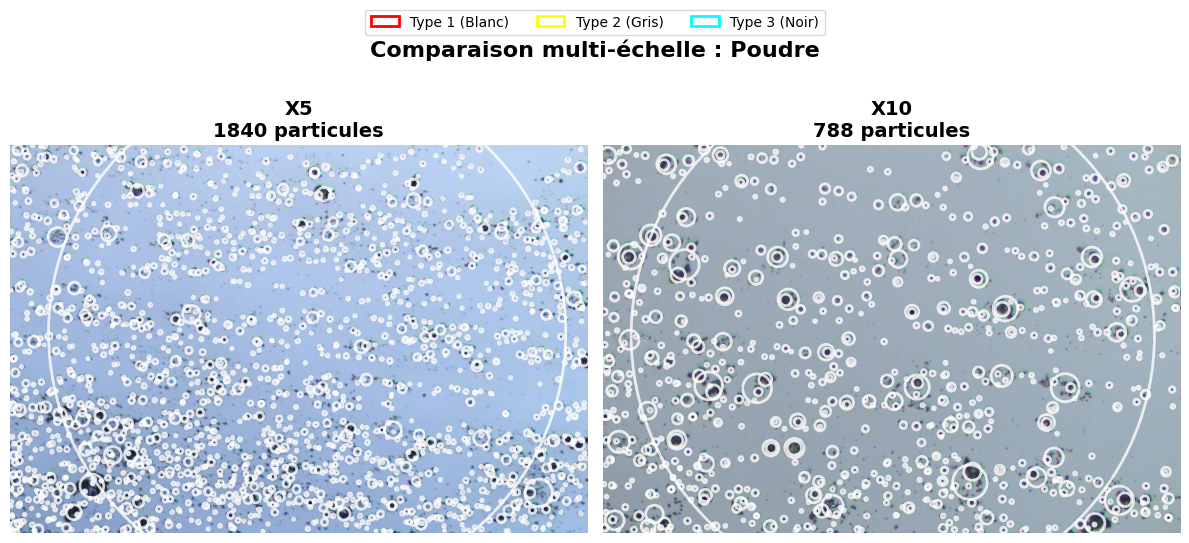

✓ Visualisation sauvegardée: Poudre


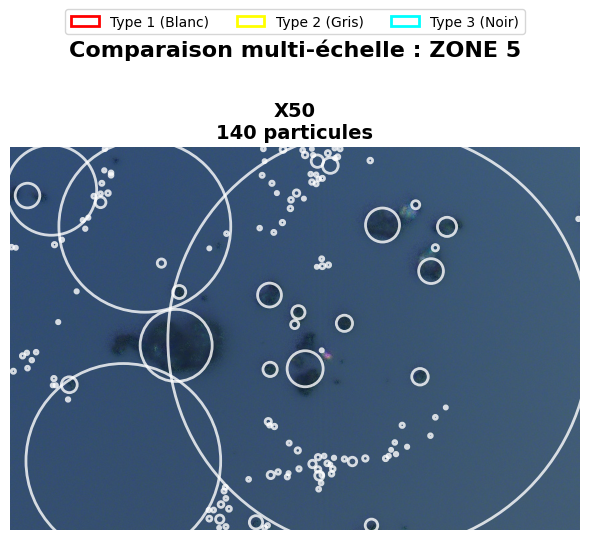

✓ Visualisation sauvegardée: ZONE 5


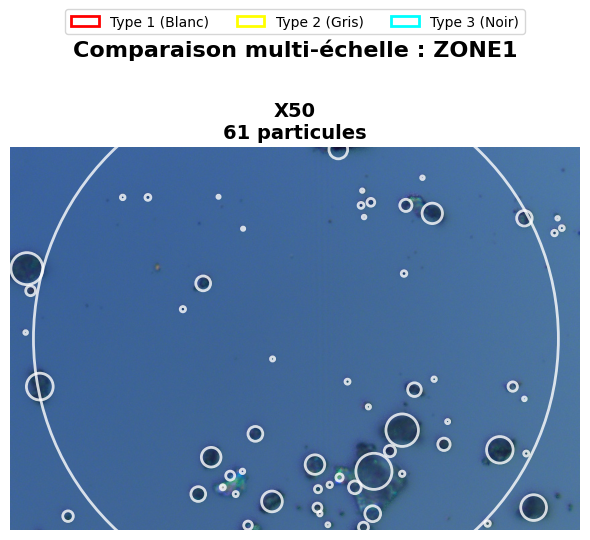

✓ Visualisation sauvegardée: ZONE1


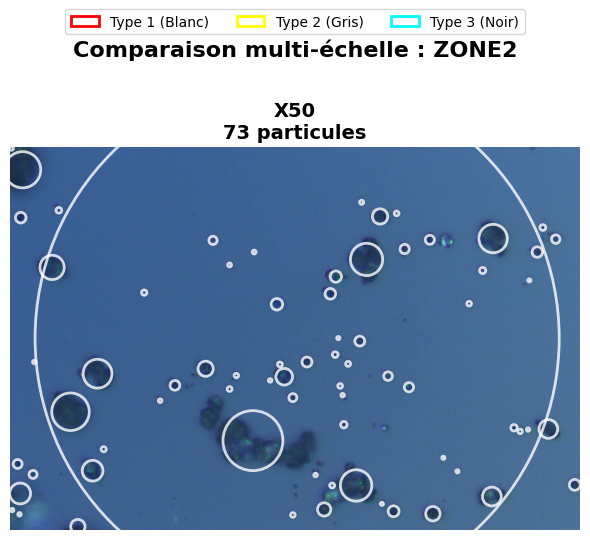

✓ Visualisation sauvegardée: ZONE2


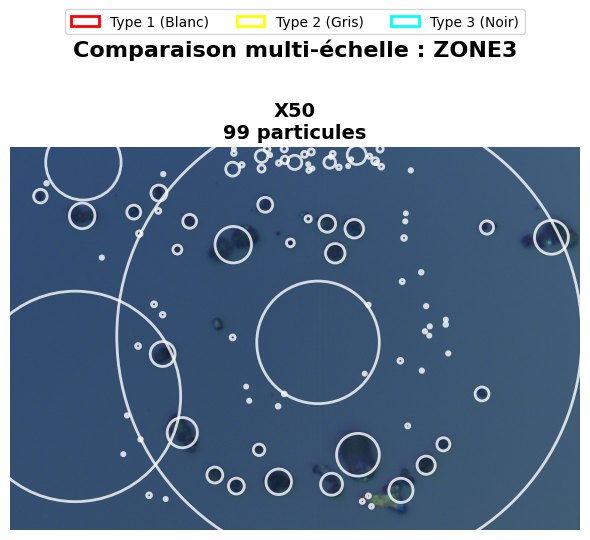

✓ Visualisation sauvegardée: ZONE3


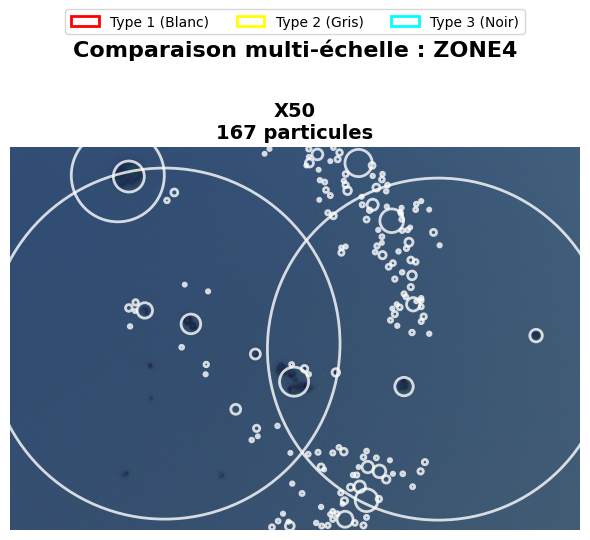

✓ Visualisation sauvegardée: ZONE4


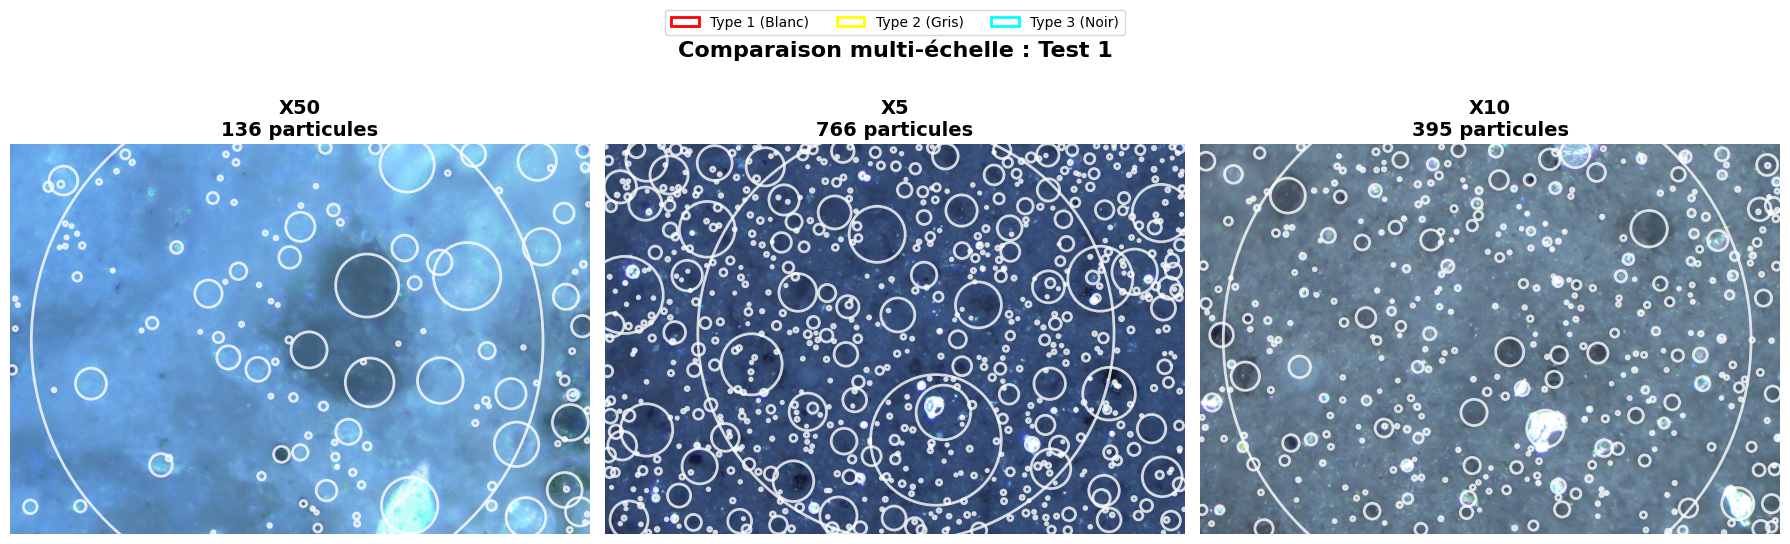

✓ Visualisation sauvegardée: Test 1


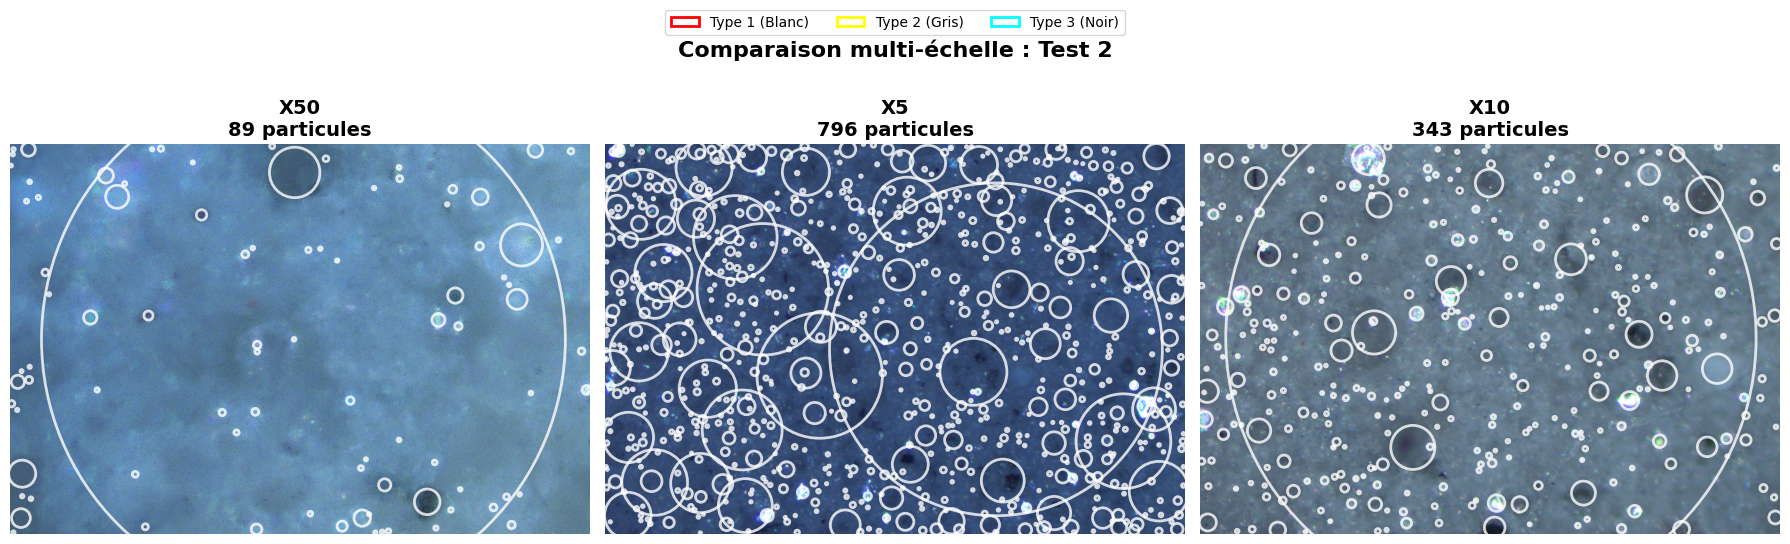

✓ Visualisation sauvegardée: Test 2


In [16]:
# =============================
# VISUALISATION SIDE-BY-SIDE
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_particles_on_image(img_path, particles_df, title, min_area=5):
    """Dessine les particules détectées sur l'image"""
    # Charger l'image
    abs_path = Path(img_path).resolve()
    try:
        pil_img = Image.open(abs_path)
        if pil_img.mode != 'RGB':
            pil_img = pil_img.convert('RGB')
        img = np.array(pil_img)
    except:
        img = cv2.imread(str(abs_path))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            return None, None
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img)
    ax.set_title(f"{title}\n{len(particles_df)} particules", fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # Couleurs par type
    colors = {'Type_1_Blanc': 'red', 'Type_2_Gris': 'yellow', 'Type_3_Noir': 'cyan'}
    
    # Dessiner chaque particule
    for _, row in particles_df.iterrows():
        if row['Area_px2'] < min_area:
            continue
        
        # Utiliser Particle_Type si disponible, sinon blanc
        if 'Particle_Type' in row.index:
            particle_type = row['Particle_Type']
            color = colors.get(particle_type, 'white')
        else:
            color = 'white'
        
        circle = patches.Circle(
            (row['Center_X'], row['Center_Y']),
            radius=np.sqrt(row['Area_px2'] / np.pi),
            linewidth=1.5,
            edgecolor=color,
            facecolor='none',
            alpha=0.7
        )
        ax.add_patch(circle)
    
    # Légende
    legend_elements = [
        patches.Patch(facecolor='none', edgecolor='red', label='Type 1 (Blanc)'),
        patches.Patch(facecolor='none', edgecolor='yellow', label='Type 2 (Gris)'),
        patches.Patch(facecolor='none', edgecolor='cyan', label='Type 3 (Noir)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    return fig, ax

def visualize_multiscale_sample(sample_name, samples_dict, base_out_path, sample_type):
    """Visualise les particules d'un échantillon à X5, X10, X50 côte à côte"""
    zoom_data = samples_dict.get(sample_name)
    if not zoom_data:
        print(f"⚠️  Échantillon {sample_name} introuvable")
        return
    
    # Charger les CSV de particules détectées
    sample_dir = base_out_path / sample_type / sample_name.replace(" ", "_")
    
    imgs_to_show = {}
    dfs_to_show = {}
    
    for zoom in ["X50", "X10", "X5"]:
        img_list = zoom_data.get(zoom, [])
        if not img_list:
            continue
        
        # Prendre la première image de chaque zoom
        img_path = img_list[0]
        csv_path = sample_dir / f"{zoom}_{img_path.stem}_particles.csv"
        
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            imgs_to_show[zoom] = img_path
            dfs_to_show[zoom] = df
    
    if not imgs_to_show:
        print(f"⚠️  Aucune donnée de particules pour {sample_name}")
        return
    
    # Créer la visualisation side-by-side
    n_imgs = len(imgs_to_show)
    fig, axes = plt.subplots(1, n_imgs, figsize=(6*n_imgs, 6))
    if n_imgs == 1:
        axes = [axes]
    
    for idx, (zoom, img_path) in enumerate(sorted(imgs_to_show.items(), reverse=True)):
        df = dfs_to_show[zoom]
        
        # Charger l'image
        abs_path = Path(img_path).resolve()
        try:
            pil_img = Image.open(abs_path)
            if pil_img.mode != 'RGB':
                pil_img = pil_img.convert('RGB')
            img = np.array(pil_img)
        except:
            img = cv2.imread(str(abs_path))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if img is None:
            continue
        
        ax = axes[idx]
        ax.imshow(img)
        ax.set_title(f"{zoom}\n{len(df)} particules", fontsize=14, fontweight='bold')
        ax.axis('off')
        
        # Couleurs par type
        colors = {'Type_1_Blanc': 'red', 'Type_2_Gris': 'yellow', 'Type_3_Noir': 'cyan'}
        
        # Dessiner chaque particule
        for _, row in df.iterrows():
            # Utiliser Particle_Type si disponible, sinon blanc
            if 'Particle_Type' in row.index:
                particle_type = row['Particle_Type']
                color = colors.get(particle_type, 'white')
            else:
                color = 'white'
            
            circle = patches.Circle(
                (row['Center_X'], row['Center_Y']),
                radius=np.sqrt(row['Area_px2'] / np.pi),
                linewidth=2,
                edgecolor=color,
                facecolor='none',
                alpha=0.8
            )
            ax.add_patch(circle)
    
    # Légende commune
    legend_elements = [
        patches.Patch(facecolor='none', edgecolor='red', label='Type 1 (Blanc)', linewidth=2),
        patches.Patch(facecolor='none', edgecolor='yellow', label='Type 2 (Gris)', linewidth=2),
        patches.Patch(facecolor='none', edgecolor='cyan', label='Type 3 (Noir)', linewidth=2)
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=10, 
               bbox_to_anchor=(0.5, 0.98))
    
    plt.suptitle(f"Comparaison multi-échelle : {sample_name}", 
                 fontsize=16, fontweight='bold', y=0.92)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Sauvegarder
    vis_out = OUT_ROOT / "Visualisations"
    vis_out.mkdir(exist_ok=True)
    fig.savefig(vis_out / f"{sample_type}_{sample_name.replace(' ', '_')}_comparison.png", 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Visualisation sauvegardée: {sample_name}")

# Générer les visualisations pour tous les échantillons
print("\n" + "="*60)
print("GÉNÉRATION DES VISUALISATIONS")
print("="*60)

if poudre_samples:
    for sample_name in poudre_samples.keys():
        visualize_multiscale_sample(sample_name, poudre_samples, OUT_ROOT / "Particules", "Poudre")

if compactee_samples:
    for sample_name in compactee_samples.keys():
        visualize_multiscale_sample(sample_name, compactee_samples, OUT_ROOT / "Particules", "Poudre_compactee")